# 평가문항 - 상세기준
- 주어진 영화 코퍼스를 바탕으로 워드임베딩 모델을 정상적으로 만들었다.
    - 워드임베딩의 most_similar() 메소드 결과가 의미상 바르게 나왔다.
- 영화 구분, 장르별로 target, attribute에 대한 대표성있는 단어 셋을 생성하였다.
    - 타당한 방법론을 통해 중복이 잘 제거되고 개념축을 의미적으로 잘 대표하는 단어 셋이 만들어졌다.
- WEAT score 계산 및 시각화를 정상적으로 진행하였다.
    - 전체 영화 장르별로 예술/일반 영화에 대한 편향성 WEAT score가 상식에 부합하는 수치로 얻어졌으며 이를 잘 시각화하였다.

In [1]:
# 파일 저장 커스텀 모듈

import sys
sys.path.append("../custom")

from importlib import reload
import custom_utils
reload(custom_utils)

from custom_utils import save_var, load_var


In [2]:
import konlpy
import gensim
import sklearn
import seaborn

print(konlpy.__version__)
print(gensim.__version__)
print(sklearn.__version__)
print(seaborn.__version__)

0.6.0
4.3.1
1.3.0
0.12.2


# STEP 1. 형태소 분석기를 이용하여 품사가 명사인 경우 해당 단어를 추출하기

In [5]:
# 약 15분정도 걸립니다.
from konlpy.tag import Okt
okt = Okt()
tokenized = []
with open('./data/synopsis/synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]:      # "Adjective", "Verb" 등을 포함할 수도 있습니다.
                res.append(w[0])    # 명사일 때만 tokenized 에 저장하게 됩니다. 
        tokenized.append(res)

KeyboardInterrupt: 

In [ ]:
save_var(tokenized, "synopsis_tokenized")

In [3]:
tokenized = load_var("synopsis_tokenized")

# STEP 2. 추출된 결과로 embedding model 만들기

In [7]:
from gensim.models import Word2Vec

In [ ]:
# tokenized에 담긴 데이터를 가지고 나만의 Word2Vec을 생성합니다. (Gensim 4.0 기준)
model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)  

In [ ]:
model.save("word2vec_tokenized")
tmp = model

In [8]:
model = Word2Vec.load("save/word2vec_tokenized")

In [9]:
model.wv.most_similar(positive=['영화'])

[('작품', 0.8924322724342346),
 ('다큐멘터리', 0.8464943766593933),
 ('드라마', 0.8251158595085144),
 ('영화로', 0.8076703548431396),
 ('가족영화', 0.7800189256668091),
 ('형식', 0.7788148522377014),
 ('주제', 0.7743354439735413),
 ('코미디', 0.7727371454238892),
 ('스토리', 0.7647455334663391),
 ('소재', 0.7586115002632141)]

# STEP 3. target, attribute 단어 셋 만들기

In [119]:
import os
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from konlpy import tag
from konlpy.tag import Okt

In [11]:
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

In [12]:
def read_token(file_name):
    okt = Okt()
    result = []
    with open('./data/synopsis/'+file_name, 'r') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ["Noun"]:#, "Adjective", "Verb"]:
                    result.append((word[0])) 
    return ' '.join(result)

In [173]:
def read_tokenizer(tokenizer, token_pos, file_name):
    result = []
    with open('./data/synopsis/'+file_name, 'r') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = tokenizer.pos(line)
            for word in tokenlist:
                if word[1] in [token_pos]:#, "Adjective", "Verb"]:
                    result.append((word[0])) 
    return ' '.join(result)

## 토큰화: 예술 영화 / 일반 영화

### Mecab

In [171]:
from mecab import MeCab
mecab = MeCab()

In [174]:
art_txt = 'synopsis_art.txt'
art = read_tokenizer(mecab, 'NNG', art_txt)

synopsis_art.txt 파일을 읽고 있습니다.


In [183]:
art[:100]

'치매 할머니 시절 상처 아버지 고모 겨울 지방 방송국 라디오 은수 자연 소리 채집 라디오 프로그램 준비 은수 상우 녹음 여행 사람 날 은수 아파트 밤 사랑 사람 주체 정도 겨울 사'

In [176]:
gen_txt = 'synopsis_gen.txt'
gen = read_tokenizer(mecab, 'NNG', gen_txt)

synopsis_gen.txt 파일을 읽고 있습니다.


In [177]:
save_var(art, "art_token_mecab")
save_var(gen, "gen_token_mecab")

In [182]:
gen[:100]

'유사 연령 성별 빈부 차이 정치 입장 불문 일거 국민 통합 애국심 성역 일침 다큐멘터리 재작년 전국 민족 민주 유가족 협의회 장기 농성 인상 다큐멘터리 민들레 집단 눈 사람 사회 '

### Komoran

In [153]:
kmr = tag.Komoran()

In [154]:
words = "테이블 우주 덤블도어 책상 컴퓨터 로봇 영호 철수 도시 경기도"

In [156]:
token_list = kmr.pos(words)

In [157]:
token_list

[('테이블', 'NNP'),
 ('우주', 'NNG'),
 ('덤블도어', 'NA'),
 ('책상', 'NNP'),
 ('컴퓨터', 'NNG'),
 ('로봇', 'NNP'),
 ('영호', 'NNP'),
 ('철수', 'NNP'),
 ('도시', 'NNG'),
 ('경기도', 'NNP')]

In [158]:
for word in token_list:
    if word[1] in ['NNG'] :
        print(word[0])

우주
컴퓨터
도시


In [160]:
gen_txt = 'synopsis_gen.txt'
gen = read_tokenizer(kmr, gen_txt)

synopsis_gen.txt 파일을 읽고 있습니다.


In [161]:
gen[:20]

'연령 빈부 차이 정치 입장 불문 일거'

In [162]:
art_txt = 'synopsis_art.txt'
art = read_tokenizer(kmr, art_txt)

synopsis_art.txt 파일을 읽고 있습니다.


In [163]:
save_var(art, "art_token_kmr")
save_var(gen, "gen_token_kmr")

### Okt

In [145]:
okt = Okt()

In [149]:
token_list = okt.pos(words)
token_list

[('테이블', 'Noun'),
 ('우주', 'Noun'),
 ('덤블도어', 'Noun'),
 ('책상', 'Noun'),
 ('컴퓨터', 'Noun'),
 ('로봇', 'Noun'),
 ('영호', 'Noun'),
 ('철수', 'Noun'),
 ('도시', 'Noun'),
 ('경기도', 'Noun')]

In [ ]:
art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

art = read_token(art_txt)
gen = read_token(gen_txt)

In [13]:
art = load_var("art_token")
gen = load_var("gen_token")

### TF-IDF

In [228]:
gen = load_var("gen_token")
art = load_var("art_token")

In [229]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

print(X.shape)

(2, 41082)


In [230]:
feature_names = vectorizer.get_feature_names_out()
print(len(feature_names))
print(feature_names[:100])

41082
['가가' '가가린' '가가호호' '가감' '가게' '가격' '가결' '가경' '가계' '가계도' '가고시마' '가고일' '가공'
 '가관' '가교' '가구' '가구야' '가구점' '가금류' '가기' '가까스레' '가까스로' '가까이' '가끔' '가나' '가나다'
 '가난' '가난뱅이' '가넷' '가노' '가뇽' '가늑' '가늠' '가능' '가능성' '가다가' '가닥' '가담' '가당' '가델'
 '가도' '가동' '가두' '가둠' '가드' '가득' '가든' '가디르' '가디언' '가디언즈' '가뜩이나' '가라' '가라데'
 '가라브' '가라사대' '가라오케' '가라테' '가락' '가락지' '가람' '가람이' '가랑이' '가래' '가래떡' '가량'
 '가렐' '가렛' '가려움' '가려진' '가령' '가례' '가로' '가로등' '가로막' '가로수' '가로수길' '가루' '가루다'
 '가루비누' '가루타' '가르마' '가르미슈' '가르시아' '가르침' '가르페' '가리봉' '가리봉동' '가리왕산' '가마'
 '가마니' '가마쿠라' '가망' '가면' '가면라이더' '가면무도회' '가명' '가모' '가몬' '가무' '가문']


> 이거 왜 한자로 나오지? 글자가 깨졌나...? 

In [187]:
vocab_index = vectorizer.vocabulary_['히트']
print(vocab_index)
print(vectorizer.get_feature_names_out()[vocab_index])

26885
히트


### 예술/일반 대표 단어들

In [231]:
m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 sparse matrix를 가져옵니다. 
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 sparse matrix를 가져옵니다. 

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 

In [189]:
print(len(w1), len(w2))

13298 25171


In [190]:
print(f'예술영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names_out()[w1[i][0]], end=', ')

print('\n')
    
print(f'일반영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names_out()[w2[i][0]], end=', ')

예술영화를 대표하는 단어들:
자신, 시작, 사랑, 사람, 친구, 영화, 남자, 여자, 가족, 이야기, 마을, 마음, 사건, 세상, 아버지, 아이, 엄마, 시간, 세계, 아들, 소녀, 아내, 사이, 영화제, 감독, 서로, 남편, 비밀, 여행, 인생, 학교, 발견, 순간, 사실, 음악, 생활, 아빠, 마지막, 행복, 기억, 모습, 죽음, 소년, 이상, 도시, 단편, 사고, 결혼, 한편, 위기, 생각, 관계, 성공, 전쟁, 일상, 경찰, 최고, 과거, 인간, 현실, 상황, 결심, 운명, 여인, 하루, 이름, 이후, 준비, 위험, 동안, 감정, 충격, 살인, 부모, 존재, 연인, 어머니, 희망, 특별, 결국, 청년, 국제, 시절, 동생, 작가, 작품, 여성, 상처, 모두, 사회, 목숨, 할머니, 진실, 매력, 계획, 제안, 만남, 이유, 자리, 배우, 

일반영화를 대표하는 단어들:
자신, 영화제, 사람, 시작, 영화, 친구, 국제, 남자, 사랑, 이야기, 여자, 사건, 남편, 가족, 아이, 아버지, 세계, 시간, 단편, 마을, 엄마, 마음, 아들, 모습, 관계, 감독, 생각, 작품, 사이, 세상, 발견, 아내, 여성, 소녀, 사실, 애니메이션, 이상, 인간, 생활, 죽음, 결혼, 비밀, 상황, 학교, 기억, 도시, 여행, 소년, 한편, 순간, 서로, 과거, 경찰, 동안, 마지막, 현실, 전쟁, 존재, 일상, 주인공, 사회, 사고, 어머니, 연출, 인생, 섹스, 다큐멘터리, 부문, 살인, 위험, 행복, 최고, 의도, 위기, 동생, 조직, 부부, 회사, 계획, 이후, 시절, 성공, 아빠, 결국, 문제, 하루, 음악, 부모, 운명, 감정, 경쟁, 사진, 결심, 할머니, 준비, 거대, 동료, 정체, 소리, 과정, 

In [232]:
w1_, w2_ = [], []
for i in range(200):
    w1_.append(vectorizer.get_feature_names_out()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names_out()[w2[i][0]])

In [192]:
print(len(w1_), len(w2_))

200 200


In [194]:
print(w1_[:50])
print(w2_[:50])

['자신', '시작', '사랑', '사람', '친구', '영화', '남자', '여자', '가족', '이야기', '마을', '마음', '사건', '세상', '아버지', '아이', '엄마', '시간', '세계', '아들', '소녀', '아내', '사이', '영화제', '감독', '서로', '남편', '비밀', '여행', '인생', '학교', '발견', '순간', '사실', '음악', '생활', '아빠', '마지막', '행복', '기억', '모습', '죽음', '소년', '이상', '도시', '단편', '사고', '결혼', '한편', '위기']
['자신', '영화제', '사람', '시작', '영화', '친구', '국제', '남자', '사랑', '이야기', '여자', '사건', '남편', '가족', '아이', '아버지', '세계', '시간', '단편', '마을', '엄마', '마음', '아들', '모습', '관계', '감독', '생각', '작품', '사이', '세상', '발견', '아내', '여성', '소녀', '사실', '애니메이션', '이상', '인간', '생활', '죽음', '결혼', '비밀', '상황', '학교', '기억', '도시', '여행', '소년', '한편', '순간']


### 한쪽에만 있는 대표 단어 추출

In [233]:
n = 15
n_range = 200

# w1에만 있고 w2에는 없는, 대표하는 단어를 15개 추출한다.
target_art, target_gen = [], []
for i in range(n_range):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): target_art.append(w1_[i])
    if i >= n_range-1: print(i)
        
# w2에만 있고 w1에는 없는, 대표하는 단어를 15개 추출한다.
for i in range(n_range):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): target_gen.append(w2_[i])
    # if len(target_gen) > n: break
    if i >= n_range-1: print(i)

199
199


In [196]:
save_var(target_art, "target_art_mecab")
save_var(target_gen, "target_gen_mecab")

In [235]:
target_art = load_var("target_art")
target_gen = load_var("target_gen")

In [236]:
len(target_art), len(target_gen)

(43, 43)

In [237]:
print(target_art)
print(target_gen)

['청년', '프랑스', '만남', '파리', '혼란', '작가', '마주', '노래', '갈등', '소식', '공연', '연애', '여자친구', '소개', '낯선', '찾기', '당신', '고백', '시골', '편지', '영국', '오늘', '마침내', '마치', '자살', '뉴욕', '탈출', '무대', '주변', '열정', '고양이', '천재', '첫사랑', '더욱', '약속', '역사', '의문', '동네', '행복', '파티', '달리', '여정', '전설']
['애니메이션', '연출', '부문', '섹스', '의도', '부산', '그것', '독립', '경쟁', '소리', '부천', '살해', '현장', '자기', '페스티벌', '사진', '환경', '경험', '지역', '다큐', '카메라', '공간', '행동', '중국', '또한', '방법', '공포', '영상', '대학', '판타스틱', '유혹', '인물', '상상', '노인', '공격', '가게', '대신', '게임', '위협', '변화', '형사', '노력', '전화']


> 이 단어들이 정말 대표 단어라고 할 수 있는건가???

In [239]:
target_art = load_var("target_art_mecab")
target_gen = load_var("target_gen_mecab")

In [240]:
print(target_art)
print(target_gen)

['파리', '공연', '노래', '소식', '연애', '갈등', '편지', '완벽', '고백', '시골', '고양이', '무대', '열정', '약속', '천재', '동네', '조금', '여정', '가슴', '전설', '소설', '작전', '얼굴', '의심', '등장', '이별', '폭력', '아침', '바다', '여름', '밴드', '스타', '예상', '기회', '가정', '욕망', '고통', '추억', '가운데']
['애니메이션', '연출', '섹스', '부문', '의도', '경쟁', '소리', '다큐', '환경', '독립', '페스티벌', '경험', '상상', '공간', '지역', '공포', '방법', '노인', '영상', '유혹', '공격', '형사', '노력', '마약', '표현', '동물', '요원', '장애', '요구', '제작', '청소년', '시도', '시선', '자연', '임무', '관객', '이미지', '장면', '작업']


> mecab 일반명사로 걸러낸 단어들이 okt 명사로 추출한 단어들 보다 좀 더 대표성을 띄는 것 같.....기도 하고...

## 토큰화: 장르별 텍스트

In [14]:
for genre in genre_txt:
    print(genre.split(".")[0])

synopsis_SF
synopsis_family
synopsis_show
synopsis_horror
synopsis_etc
synopsis_documentary
synopsis_drama
synopsis_romance
synopsis_musical
synopsis_mystery
synopsis_crime
synopsis_historical
synopsis_western
synopsis_adult
synopsis_thriller
synopsis_animation
synopsis_action
synopsis_adventure
synopsis_war
synopsis_comedy
synopsis_fantasy


### mecab

In [201]:
genre_tokenized_mecab = {}
for genre in genre_txt:
    genre_name = genre.split(".")[0]
    genre_tokenized_mecab[genre_name] = read_tokenizer(mecab, 'NNG', genre)
    save_var(genre_tokenized_mecab[genre_name], f"{genre_name}_tokenized_mecab")

synopsis_SF.txt 파일을 읽고 있습니다.
synopsis_family.txt 파일을 읽고 있습니다.
synopsis_show.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.
synopsis_etc.txt 파일을 읽고 있습니다.
synopsis_documentary.txt 파일을 읽고 있습니다.
synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_musical.txt 파일을 읽고 있습니다.
synopsis_mystery.txt 파일을 읽고 있습니다.
synopsis_crime.txt 파일을 읽고 있습니다.
synopsis_historical.txt 파일을 읽고 있습니다.
synopsis_western.txt 파일을 읽고 있습니다.
synopsis_adult.txt 파일을 읽고 있습니다.
synopsis_thriller.txt 파일을 읽고 있습니다.
synopsis_animation.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_adventure.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_fantasy.txt 파일을 읽고 있습니다.


In [166]:
f_name = "genre_tokenized_kmr"

In [167]:
save_var(genre_tokenized_kmr, f_name)
temp = genre_tokenized_kmr

In [168]:
genre_tokenized_kmr = load_var(f_name)

In [169]:
len(genre_tokenized_kmr)

21

In [170]:
genre_tokenized_kmr.keys()

dict_keys(['synopsis_SF', 'synopsis_family', 'synopsis_show', 'synopsis_horror', 'synopsis_etc', 'synopsis_documentary', 'synopsis_drama', 'synopsis_romance', 'synopsis_musical', 'synopsis_mystery', 'synopsis_crime', 'synopsis_historical', 'synopsis_western', 'synopsis_adult', 'synopsis_thriller', 'synopsis_animation', 'synopsis_action', 'synopsis_adventure', 'synopsis_war', 'synopsis_comedy', 'synopsis_fantasy'])

In [32]:
genre_names = [genre.split(".")[0].split("_")[1] for genre in genre_txt]
genre_names

['SF',
 'family',
 'show',
 'horror',
 'etc',
 'documentary',
 'drama',
 'romance',
 'musical',
 'mystery',
 'crime',
 'historical',
 'western',
 'adult',
 'thriller',
 'animation',
 'action',
 'adventure',
 'war',
 'comedy',
 'fantasy']

In [35]:
genre = []
for genre_name in genre_names:
    genre.append(genre_tokenized[genre_name])
len(genre)

21

In [36]:
save_var(genre, "genre")

In [37]:
genre = load_var("genre")
len(genre)

21

### komoran

In [165]:
genre_tokenized_kmr = {}
for genre in genre_txt:
    genre_name = genre.split(".")[0]
    genre_tokenized_kmr[genre_name] = read_tokenizer(kmr, genre)
    save_var(genre_tokenized_kmr[genre_name], f"{genre_name}_tokenized_kmr")

synopsis_SF.txt 파일을 읽고 있습니다.
synopsis_family.txt 파일을 읽고 있습니다.
synopsis_show.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.
synopsis_etc.txt 파일을 읽고 있습니다.
synopsis_documentary.txt 파일을 읽고 있습니다.
synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_musical.txt 파일을 읽고 있습니다.
synopsis_mystery.txt 파일을 읽고 있습니다.
synopsis_crime.txt 파일을 읽고 있습니다.
synopsis_historical.txt 파일을 읽고 있습니다.
synopsis_western.txt 파일을 읽고 있습니다.
synopsis_adult.txt 파일을 읽고 있습니다.
synopsis_thriller.txt 파일을 읽고 있습니다.
synopsis_animation.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_adventure.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_fantasy.txt 파일을 읽고 있습니다.


In [202]:
f_name = "genre_tokenized_mecab"

In [203]:
save_var(genre_tokenized_mecab, f_name)
temp = genre_tokenized_mecab

In [204]:
genre_tokenized_mecab = load_var(f_name)

In [205]:
len(genre_tokenized_mecab)

21

In [206]:
genre_tokenized_mecab.keys()

dict_keys(['synopsis_SF', 'synopsis_family', 'synopsis_show', 'synopsis_horror', 'synopsis_etc', 'synopsis_documentary', 'synopsis_drama', 'synopsis_romance', 'synopsis_musical', 'synopsis_mystery', 'synopsis_crime', 'synopsis_historical', 'synopsis_western', 'synopsis_adult', 'synopsis_thriller', 'synopsis_animation', 'synopsis_action', 'synopsis_adventure', 'synopsis_war', 'synopsis_comedy', 'synopsis_fantasy'])

In [209]:
genre_names = [genre.split(".")[0] for genre in genre_txt]
genre_names

['synopsis_SF',
 'synopsis_family',
 'synopsis_show',
 'synopsis_horror',
 'synopsis_etc',
 'synopsis_documentary',
 'synopsis_drama',
 'synopsis_romance',
 'synopsis_musical',
 'synopsis_mystery',
 'synopsis_crime',
 'synopsis_historical',
 'synopsis_western',
 'synopsis_adult',
 'synopsis_thriller',
 'synopsis_animation',
 'synopsis_action',
 'synopsis_adventure',
 'synopsis_war',
 'synopsis_comedy',
 'synopsis_fantasy']

In [207]:
genre_names = [genre.split(".")[0].split("_")[1] for genre in genre_txt]
genre_names

['SF',
 'family',
 'show',
 'horror',
 'etc',
 'documentary',
 'drama',
 'romance',
 'musical',
 'mystery',
 'crime',
 'historical',
 'western',
 'adult',
 'thriller',
 'animation',
 'action',
 'adventure',
 'war',
 'comedy',
 'fantasy']

In [210]:
genre = []
for genre_name in genre_names:
    genre.append(genre_tokenized_mecab[genre_name])
len(genre)

21

In [211]:
save_var(genre, "genre_mecab")

In [212]:
genre = load_var("genre_mecab")
len(genre)

21

### okt

In [15]:
genre_tokenized = {}
for genre in genre_txt:
    genre_name = genre.split(".")[0]
    genre_tokenized[genre_name] = read_token(genre)
    save_var(genre_tokenized[genre_name], f"{genre_name}_tokenized")

synopsis_SF.txt 파일을 읽고 있습니다.
synopsis_family.txt 파일을 읽고 있습니다.
synopsis_show.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.
synopsis_etc.txt 파일을 읽고 있습니다.
synopsis_documentary.txt 파일을 읽고 있습니다.
synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_musical.txt 파일을 읽고 있습니다.
synopsis_mystery.txt 파일을 읽고 있습니다.
synopsis_crime.txt 파일을 읽고 있습니다.
synopsis_historical.txt 파일을 읽고 있습니다.
synopsis_western.txt 파일을 읽고 있습니다.
synopsis_adult.txt 파일을 읽고 있습니다.
synopsis_thriller.txt 파일을 읽고 있습니다.
synopsis_animation.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_adventure.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_fantasy.txt 파일을 읽고 있습니다.


In [27]:
f_name = "genre_tokenized"

In [ ]:
save_var(genre_tokenized, f_name)
temp = genre_tokenized

In [28]:
genre_tokenized = load_var(f_name)

In [29]:
genre_tokenized.keys()

dict_keys(['synopsis_SF', 'synopsis_family', 'synopsis_show', 'synopsis_horror', 'synopsis_etc', 'synopsis_documentary', 'synopsis_drama', 'synopsis_romance', 'synopsis_musical', 'synopsis_mystery', 'synopsis_crime', 'synopsis_historical', 'synopsis_western', 'synopsis_adult', 'synopsis_thriller', 'synopsis_animation', 'synopsis_action', 'synopsis_adventure', 'synopsis_war', 'synopsis_comedy', 'synopsis_fantasy'])

In [33]:
genre_names = [genre.split(".")[0] for genre in genre_txt]
genre_names

['synopsis_SF',
 'synopsis_family',
 'synopsis_show',
 'synopsis_horror',
 'synopsis_etc',
 'synopsis_documentary',
 'synopsis_drama',
 'synopsis_romance',
 'synopsis_musical',
 'synopsis_mystery',
 'synopsis_crime',
 'synopsis_historical',
 'synopsis_western',
 'synopsis_adult',
 'synopsis_thriller',
 'synopsis_animation',
 'synopsis_action',
 'synopsis_adventure',
 'synopsis_war',
 'synopsis_comedy',
 'synopsis_fantasy']

In [32]:
genre_names = [genre.split(".")[0].split("_")[1] for genre in genre_txt]
genre_names

['SF',
 'family',
 'show',
 'horror',
 'etc',
 'documentary',
 'drama',
 'romance',
 'musical',
 'mystery',
 'crime',
 'historical',
 'western',
 'adult',
 'thriller',
 'animation',
 'action',
 'adventure',
 'war',
 'comedy',
 'fantasy']

In [35]:
genre = []
for genre_name in genre_names:
    genre.append(genre_tokenized[genre_name])
len(genre)

21

In [36]:
save_var(genre, "genre")

In [37]:
genre = load_var("genre")
len(genre)

21

### 대표 단어 추출

In [38]:
def extract_sorted_features(X):
    """Returns features sorted by TF-IDF score."""
    coo_matrices = [X[i].tocoo() for i in range(X.shape[0])]
    sorted_features = [
        sorted(zip(mm.col, mm.data), key=lambda x: x[1], reverse=True) 
        for mm in coo_matrices
    ]
    return sorted_features

In [39]:
def extract_attributes(sorted_features, vectorizer, model, max_attributes=100, selection=False):
    """Extracts representative attributes for each genre."""
    attributes = []
    selected_attributes = set()  # 선택된 단어들 세트
    
    feature_names = vectorizer.get_feature_names_out()
    for feature_list in sorted_features:
        attr = []
        for col_idx, _ in feature_list:
            word = feature_names[col_idx]
            # 다른 장르에서 선택된 단어들이 아닌 단어를 선택
            # 좋은 방법은 아닌 것 같다...
            if word in model.wv and word not in selected_attributes:
                attr.append(word)
                selected_attributes.add(word)  # 선택된 단어를 세트에 추가
            if len(attr) >= max_attributes:
                break
        attributes.append(attr)
    
    return attributes

In [214]:
vectorizer = TfidfVectorizer()
# vectorizer = TfidfVectorizer(max_df=0.7, min_df=0.5)
X = vectorizer.fit_transform(genre)

print(X.shape)

(21, 27479)


In [215]:
# Extract features sorted by TF-IDF score
sorted_features = extract_sorted_features(X)

# Extract representative attributes for each genre
attributes = extract_attributes(sorted_features, vectorizer, model, max_attributes=20, selection=False)

In [216]:
f_name = "attributes_default_mecab"
# f_name = "attributes_selection_max070"

In [217]:
save_var(attributes, f_name)
tmp = attributes

### 대표 단어 추출: 확인

In [102]:
f_name = "attributes_default_20230822_110628"
# f_name = "attributes_selection_max070"

In [103]:
attributes = load_var(f_name)

In [104]:
for genre_name, attr in zip(genre_names, attributes):
    print(f"{genre_name}: {', '.join(attr)}")

synopsis_SF: 위해, 자신, 지구, 시작, 사람, 인류, 인간, 미래, 우주, 그녀, 로봇, 세계, 모든, 박사, 우주선, 외계, 존재, 세상, 발견, 행성, 정체, 친구
synopsis_family: 엄마, 아빠, 가족, 영화제, 자신, 위해, 친구, 아주르, 아버지, 시작, 그녀, 아들, 마을, 국제, 낙타, 할머니, 씨제이, 동구, 사랑, 아이, 사람, 학교
synopsis_show: 오페라, 사랑, 토스카, 실황, 올레, 자신, 카바, 그녀, 공연, 오텔로, 리골레토, 백작, 프레, 베르디, 위해, 카르피, 비바, 왕자, 콘서트, 백작부인, 반니, 아리아
synopsis_horror: 시작, 위해, 사람, 자신, 친구, 그녀, 사건, 공포, 발견, 죽음, 마을, 가족, 악령, 남자, 좀비, 영화, 사실, 소녀, 하나, 살인, 이야기, 비밀
synopsis_etc: 영화제, 국제, 서울, 단편, 영화, 자신, 사람, 이야기, 그녀, 남자, 위해, 시작, 사랑, 뉴미디어, 페스티벌, 여자, 대한, 독립, 친구, 작품, 엄마, 통해
synopsis_documentary: 영화제, 영화, 다큐, 국제, 다큐멘터리, 사람, 이야기, 대한, 자신, 감독, 위해, 서울, 우리, 시작, 세계, 통해, 그녀, 여성, 가족, 한국, 작품, 환경
synopsis_drama: 자신, 영화제, 그녀, 사람, 사랑, 영화, 위해, 시작, 국제, 남자, 친구, 이야기, 엄마, 여자, 아버지, 가족, 단편, 서울, 대한, 아들, 마음, 아이
synopsis_romance: 그녀, 사랑, 자신, 시작, 남편, 남자, 여자, 사람, 친구, 섹스, 위해, 마음, 결혼, 서로, 아내, 관계, 부부, 엄마, 아버지, 사실, 영화, 점점
synopsis_musical: 뮤지컬, 사랑, 에스메랄다, 그녀, 음악, 충무로, 모차르트, 영화, 토스카, 자신, 니웨, 카바, 영화제, 바흐, 페뷔스, 프롤, 모도, 카르피, 시작, 제루샤, 샤오캉, 위해
synopsis_mystery: 사건,

> TFIDF: default  
> 그녀, 자신, 시작, 여자, 남자, 친구, 이야기 등등 중복된 단어들이 많이 보인다. 

In [102]:
f_name = "attributes_selection"
attributes = load_var(f_name)

In [401]:
for genre_name, attr in zip(genre_names, attributes):
    print(f"{genre_name}: {', '.join(attr)}")

synopsis_SF: 위해, 자신, 지구, 시작, 사람, 인류, 인간, 미래, 우주, 그녀, 로봇, 세계, 모든, 박사, 우주선, 외계, 존재, 세상, 발견, 행성
synopsis_family: 엄마, 아빠, 가족, 영화제, 친구, 아주르, 아버지, 아들, 마을, 국제, 낙타, 할머니, 씨제이, 동구, 사랑, 아이, 학교, 소년, 슈이트, 이야기
synopsis_show: 오페라, 토스카, 실황, 올레, 카바, 공연, 오텔로, 리골레토, 백작, 프레, 베르디, 카르피, 비바, 왕자, 콘서트, 백작부인, 반니, 아리아, 미노, 차이코프스키
synopsis_horror: 사건, 공포, 죽음, 악령, 남자, 좀비, 영화, 사실, 소녀, 하나, 살인, 비밀, 정체, 저주, 살해, 여자, 의문, 점점, 사고, 명의
synopsis_etc: 서울, 단편, 뉴미디어, 페스티벌, 대한, 독립, 작품, 통해, 아시아나, 다른, 우리, 연출, 모습, 시간, 이미지, 부산, 기억, 상영작, 지하철, 청소년
synopsis_documentary: 다큐, 다큐멘터리, 감독, 여성, 한국, 환경, 사회, 노동자, 가장, 기록, 역사, 음악, 미국, 카메라, 동안, 대해, 과정, 도시, 지역, 투쟁
synopsis_drama: 마음, 남편, 서로, 다시, 관계, 생각, 아내, 사이, 때문, 부문, 어머니, 생활, 결혼, 인생, 간다, 순간, 여행, 현실, 일상, 의도
synopsis_romance: 섹스, 부부, 회사, 유혹, 연애, 애인, 새엄마, 불륜, 남자친구, 유부녀, 감정, 정사, 출장, 선배, 과연, 여자친구, 커플, 한편, 만난, 고백
synopsis_musical: 뮤지컬, 에스메랄다, 충무로, 모차르트, 니웨, 바흐, 페뷔스, 프롤, 모도, 제루샤, 샤오캉, 데이비, 팬텀, 최고, 크리스틴, 애니, 노트르담, 라훌, 캬바레, 안젤로
synopsis_mystery: 진실, 민혁, 미스터리, 형사, 경찰, 현우, 발생, 방독면, 범인, 모두, 충격, 소설, 용의자, 여인,

> TFIDF: word selection  
> 중복된 단어들이 제거되었다. 

In [102]:
f_name = "attributes_default_max085"
attributes = load_var(f_name)

In [411]:
for genre_name, attr in zip(genre_names, attributes):
    print(f"{genre_name}: {', '.join(attr)}")

synopsis_SF: 지구, 인류, 우주, 로봇, 박사, 우주선, 외계, 행성, 실험, 시스템, 위협, 생명체, 스타크, 리플리, 과학자, 파괴, 켈빈, 컨트, 수퍼맨, 요원
synopsis_family: 아주르, 낙타, 씨제이, 동구, 슈이트, 마갈, 미아, 펠리칸, 벤트, 케이시, 할아버지, 엠마, 고양이, 크리스마스, 최호, 요정, 혜지, 유나, 테리, 번개
synopsis_show: 오페라, 토스카, 실황, 올레, 카바, 공연, 오텔로, 리골레토, 백작, 프레, 베르디, 카르피, 비바, 왕자, 콘서트, 백작부인, 반니, 아리아, 미노, 차이코프스키
synopsis_horror: 악령, 좀비, 저주, 의문, 시체, 악몽, 유령, 게임, 귀신, 악마, 바이러스, 부부, 현상, 사라, 괴물, 살인마, 판타스틱, 부천, 인형, 그날
synopsis_etc: 단편, 뉴미디어, 페스티벌, 독립, 아시아나, 연출, 이미지, 상영작, 지하철, 청소년, 노인, 포럼, 메트로, 단편영화, 풍경, 부문, 실험영화, 애니메이션, 대화, 배우
synopsis_documentary: 다큐, 다큐멘터리, 환경, 노동자, 투쟁, 인디다큐페스티발, 북한, 문화, 건축, 인터뷰, 자연, 질문, 관객, 당시, 여정, 등반, 밴드, 노래, 인권영화제, 건축사
synopsis_drama: 상처, 회사, 애인, 섹스, 남자친구, 전주, 동네, 오늘, 선생님, 마치, 관심, 여자친구, 로서, 드라마, 퀴어, 표현, 고백, 초청, 고등학교, 이혼
synopsis_romance: 연애, 새엄마, 불륜, 유부녀, 정사, 출장, 선배, 동거, 시아버지, 욕구, 마사지, 성욕, 은밀, 직장, 언니, 형부, 자위, 형수, 현우, 위로
synopsis_musical: 뮤지컬, 에스메랄다, 충무로, 모차르트, 니웨, 바흐, 페뷔스, 프롤, 모도, 제루샤, 샤오캉, 데이비, 팬텀, 크리스틴, 애니, 노트르담, 라훌, 캬바레, 안젤로, 파두
synopsis_mystery: 민혁, 미스터리, 형사, 방독면, 용

> TFIDF: default, max 0.85  
> 중복된 단어들이 잘 보이지 않는다.  
> 그러나... 고유명사들(스타크, 리플리, 아주르, 케이시, 혜지, 유나 등)이 많이 선택되어 적절한 대표단어가 추출된 것 같지는 않다.  

In [102]:
f_name = "attributes_selection_max085"
attributes = load_var(f_name)

In [63]:
for genre_name, attr in zip(genre_names, attributes):
    print(f"{genre_name}: {', '.join(attr)}")

synopsis_SF: 지구, 인류, 우주, 로봇, 박사, 우주선, 외계, 행성, 실험, 시스템, 위협, 생명체, 스타크, 리플리, 과학자, 파괴, 켈빈, 컨트, 수퍼맨, 요원
synopsis_family: 아주르, 낙타, 씨제이, 동구, 슈이트, 마갈, 미아, 펠리칸, 벤트, 케이시, 할아버지, 엠마, 고양이, 크리스마스, 최호, 요정, 혜지, 유나, 테리, 번개
synopsis_show: 오페라, 토스카, 실황, 올레, 카바, 공연, 오텔로, 리골레토, 백작, 프레, 베르디, 카르피, 비바, 왕자, 콘서트, 백작부인, 반니, 아리아, 미노, 차이코프스키
synopsis_horror: 악령, 좀비, 저주, 의문, 시체, 악몽, 유령, 게임, 귀신, 악마, 바이러스, 부부, 현상, 사라, 괴물, 살인마, 판타스틱, 부천, 인형, 그날
synopsis_etc: 단편, 뉴미디어, 페스티벌, 독립, 아시아나, 연출, 이미지, 상영작, 지하철, 청소년, 노인, 포럼, 메트로, 단편영화, 풍경, 부문, 실험영화, 애니메이션, 대화, 배우
synopsis_documentary: 다큐, 다큐멘터리, 환경, 노동자, 투쟁, 인디다큐페스티발, 북한, 문화, 건축, 인터뷰, 자연, 질문, 관객, 당시, 여정, 등반, 밴드, 노래, 인권영화제, 건축사
synopsis_drama: 상처, 회사, 애인, 섹스, 남자친구, 전주, 동네, 오늘, 선생님, 마치, 관심, 여자친구, 로서, 드라마, 퀴어, 표현, 고백, 초청, 고등학교, 이혼
synopsis_romance: 연애, 새엄마, 불륜, 유부녀, 정사, 출장, 선배, 동거, 시아버지, 욕구, 마사지, 성욕, 은밀, 직장, 언니, 형부, 자위, 형수, 현우, 위로
synopsis_musical: 뮤지컬, 에스메랄다, 충무로, 모차르트, 니웨, 바흐, 페뷔스, 프롤, 모도, 제루샤, 샤오캉, 데이비, 팬텀, 크리스틴, 애니, 노트르담, 라훌, 캬바레, 안젤로, 파두
synopsis_mystery: 민혁, 미스터리, 형사, 방독면, 용

> TDIDF: 중복단어 제거, max 0.85  

In [108]:
f_name = "attributes_default_max070"
attributes = load_var(f_name)

In [109]:
for genre_name, attr in zip(genre_names, attributes):
    print(f"{genre_name}: {', '.join(attr)}")

synopsis_SF: 인류, 우주, 우주선, 외계, 행성, 시스템, 생명체, 외계인, 바이러스, 대원, 멸망, 감염, 거대, 토니, 슈퍼, 통제, 데이빗, 군단, 무차별, 공룡
synopsis_family: 미아, 요정, 테리, 번개, 손녀, 스튜어트, 해나, 아스, 장난감, 노동자, 마르, 강아지, 타일러, 마법, 입양, 백화점, 이스라엘, 어린이, 일리, 꼬마
synopsis_show: 공작, 레오, 벨라, 발레, 스카, 미나, 지휘, 왕비, 카르멘, 데스, 카라, 도의, 줄리엣, 고문, 임명, 수수께끼, 주체, 해적, 하인, 알바
synopsis_horror: 살인마, 뱀파이어, 레드, 에이미, 사투, 실체, 레이첼, 클레어, 아담, 미장센, 오두막, 에밀리, 여고생, 애니, 지하실, 엘리베이터, 태국, 느낌, 간호사, 고장
synopsis_etc: 아시아나, 지하철, 단편영화, 애니메이션, 디지털, 장애인, 질문, 교통, 언어, 사물, 소통, 화면, 에리, 오디션, 관점, 건축, 자전거, 탐구, 인터뷰, 여학생
synopsis_documentary: 투쟁, 밴드, 세대, 공동체, 쓰레기, 산업, 교육, 혁명, 이주, 산악, 음식, 노동, 영향, 대통령, 증언, 예술가, 아프리카, 대한민국, 요리, 이란
synopsis_drama: 섹스, 선생님, 고등학교, 연애, 선배, 아시아, 축구, 아르바이트, 데이트, 수술, 장례식, 공부, 주목, 젊은이, 경기, 불법, 불륜, 모델, 택시, 심사
synopsis_romance: 정사, 출장, 스케, 재혼, 정식, 손길, 정우, 잠자리, 이치, 아키, 출근, 자꾸만, 며느리, 외도, 행각, 카페, 육체, 소연, 몸매, 수연
synopsis_musical: 뮤지컬, 크리스틴, 성당, 집시, 포르노, 하우스, 무당, 음악가, 예수, 삼각관계, 시티, 레인, 미키, 카일, 베이징, 단장, 문학, 지기, 허가, 뜻밖
synopsis_mystery: 용의자, 사이먼, 한나, 여관, 동영상, 연관, 승객, 살인자, 재판, 

In [218]:
f_name = "attributes_default_mecab"
attributes = load_var(f_name)

In [219]:
for genre_name, attr in zip(genre_names, attributes):
    print(f"{genre_name}: {', '.join(attr)}")

synopsis_SF: 자신, 지구, 시작, 사람, 인류, 인간, 세계, 우주, 미래, 로봇, 박사, 친구, 거대, 외계, 우주선, 생명체, 존재, 세상, 발견, 시간
synopsis_family: 엄마, 아빠, 영화제, 가족, 아버지, 아들, 사랑, 마을, 국제, 아이, 낙타, 할머니, 학교, 행복, 소년, 이야기, 어머니, 소녀, 미아, 할아버지
synopsis_show: 오페라, 실황, 백작, 카바, 토스카, 공연, 리골레토, 왕자, 콘서트, 만리, 오텔로, 로지, 음악, 메스, 라다, 무대, 도시, 공작, 결혼, 사이
synopsis_horror: 공포, 사건, 죽음, 남자, 이상, 영화, 여자, 악령, 사실, 비밀, 병원, 저주, 살인, 사고, 의문, 이후, 일행, 시체, 정신, 정체
synopsis_etc: 단편, 페스티벌, 미디어, 작품, 독립, 연출, 모습, 이미지, 기억, 현실, 감독, 지하철, 관계, 청소년, 여성, 생각, 의도, 공간, 노인, 여행
synopsis_documentary: 다큐, 다큐멘터리, 환경, 사회, 역사, 노동자, 기록, 동안, 카메라, 과정, 문제, 일상, 지역, 투쟁, 전쟁, 변화, 건축, 인권, 문화, 인터뷰
synopsis_drama: 마음, 남편, 아내, 부문, 생활, 서로, 인생, 순간, 상황, 감정, 경쟁, 하루, 마지막, 과거, 부모, 상처, 시절, 결심, 한편, 주인공
synopsis_romance: 섹스, 부부, 회사, 유혹, 연애, 애인, 새엄마, 정사, 유부녀, 선배, 커플, 출장, 고백, 매력, 시아버지, 만남, 제안, 이혼, 성욕, 동거
synopsis_musical: 뮤지컬, 팬텀, 크리스틴, 최고, 노트르담, 파두, 노래, 성당, 집시, 발레, 파리, 연화, 서영, 오강, 솔리스트, 배우, 포르노, 파티, 열정, 수박
synopsis_mystery: 진실, 형사, 미스터리, 경찰, 현우, 발생, 방독면, 범인, 연쇄, 소설, 충격, 게임, 여인, 용의자, 추적, 사진, 조사, 의심, 수사, 

> Mecab 일반명사로 추출된 단어들을 사용한 결과,  
> 고유명사가 덜 섞여 나온다.

# STEP 4. WEAT score 계산과 시각화

In [55]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_heatmap(matrix, genre_names, title='Art/General Movie Heatmap', font_scale=0.7, figsize=(8, 6)):
    np.random.seed(0)

    sns.set_style("whitegrid")
    sns.set_context("talk", font_scale=font_scale)
    sns.set(font='courier')

    plt.rcParams['axes.unicode_minus'] = False
    plt.figure(figsize=figsize)

    ax = sns.heatmap(
        matrix, 
        xticklabels=genre_names, 
        yticklabels=genre_names, 
        annot=True,  
        cmap='RdYlGn_r',
        annot_kws={"size": 6}
    )

    ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)
    ax.set_title(title, fontsize=15)
    ax.set_xlabel('X-axis', fontsize=12)
    ax.set_ylabel('Y-axis', fontsize=12)

    return ax

In [44]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B #, c_a, c_b

In [45]:
def weat_score(X, Y, A, B):

    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    score = (mean_X-mean_Y)/std_dev
    
    # print(score)
    
    return score

### WEAT score 계산

In [47]:
matrix = [[0 for _ in range(len(genre_names))] for _ in range(len(genre_names))]

In [48]:
X = np.array([model.wv[word] for word in target_art])
Y = np.array([model.wv[word] for word in target_gen])

In [49]:
len(X), len(Y)

(43, 43)

In [50]:
X_20 = X[:20]
Y_20 = Y[:20]

In [51]:
len(X_20), len(Y_20)

(20, 20)

In [220]:
attributes = load_var("attributes_default_mecab")

In [221]:
for i in range(len(genre_names)-1):
    for j in range(i+1, len(genre_names)):
        A = np.array([model.wv[word] for word in attributes[i]])
        B = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X_20, Y_20, A, B)

In [222]:
f_name = "genre_matrix_default_mecab"

In [223]:
save_var(matrix, f_name)
tmp = matrix

In [224]:
matrix = load_var(f_name)

In [155]:
for i in range(len(genre_names)-1):
    for j in range(i+1, len(genre_names)):
        print(genre_names[i], genre_names[j],matrix[i][j])

synopsis_SF synopsis_family 0.5834592
synopsis_SF synopsis_show -0.15665422
synopsis_SF synopsis_horror 0.40947413
synopsis_SF synopsis_etc 0.14008117
synopsis_SF synopsis_documentary 0.42085403
synopsis_SF synopsis_drama 0.53845584
synopsis_SF synopsis_romance 0.29112524
synopsis_SF synopsis_musical -0.008326557
synopsis_SF synopsis_mystery 0.10888969
synopsis_SF synopsis_crime 0.115221195
synopsis_SF synopsis_historical -0.17761096
synopsis_SF synopsis_western 0.10568356
synopsis_SF synopsis_adult 0.021710984
synopsis_SF synopsis_thriller 0.35821897
synopsis_SF synopsis_animation -0.22512354
synopsis_SF synopsis_action -0.48289287
synopsis_SF synopsis_adventure 0.016954813
synopsis_SF synopsis_war -0.07929506
synopsis_SF synopsis_comedy 0.17988038
synopsis_SF synopsis_fantasy 0.0378017
synopsis_family synopsis_show -0.5555974
synopsis_family synopsis_horror -0.58751726
synopsis_family synopsis_etc -0.50199014
synopsis_family synopsis_documentary -0.33368546
synopsis_family synopsis_d

### Heatmap

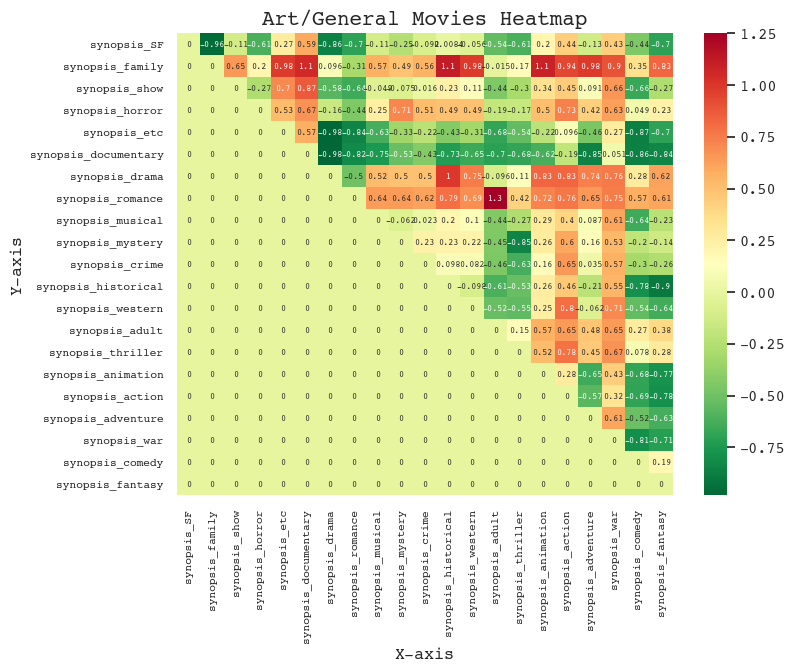

In [225]:
ax = plot_heatmap(matrix, genre_names, "Art/General Movies Heatmap")
fig = ax.get_figure()

In [226]:
save_var(fig, "plot_default_mecab")

### TF-IDF 기본 설정

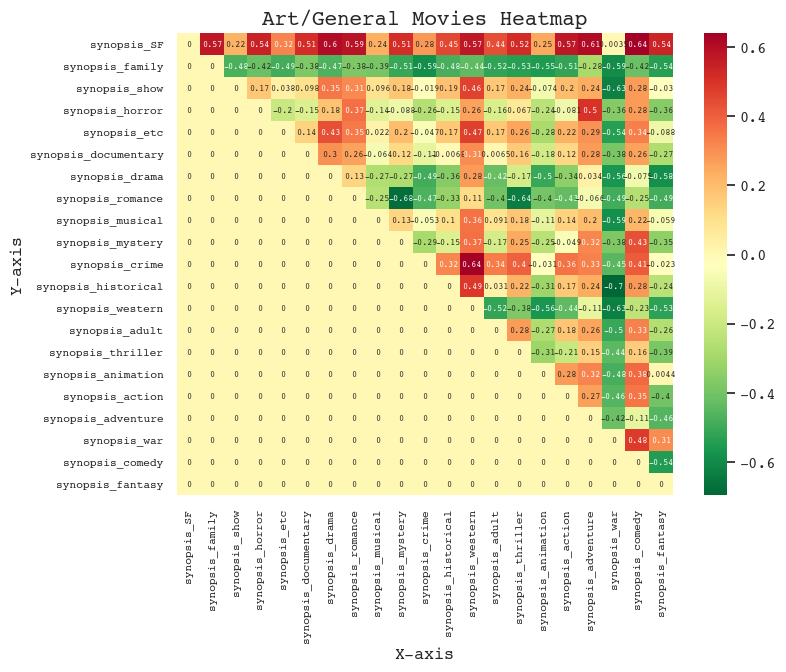

In [72]:
fig = load_var("plot_default_20230821_181539")

> SF 장르는 거의 다른 장르와의 WEAT score 값이 높게 나온다.  
> SF 장르가 다른 장르에 비해 예술 영화에 가까운 것은 좀 이상하므로, 수치를 좀 조정할 필요가 있다.

### TF-IDF 기본 설정 - 중복단어 제거

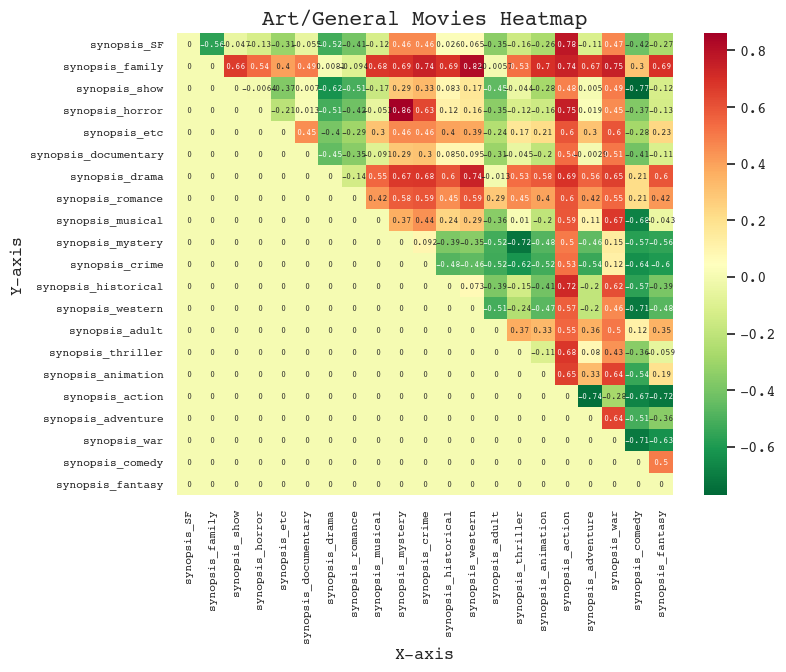

In [407]:
fig = load_var("plot_selection")
fig

> 중복되지 않는 단어를 선택한 결과,  
> SF 장르에서 거의 모든 장르와의 WEAT score 값이 높았던 부분이 많이 완화되었다.  
> family, drame, romance가 다른 장르에 비해 예술영화에 가깝다는 결과가 나왔다.  
> mystery, crime, action, war가 다른 장르에 비해 일반 영화에 가깝다는 결과가 나왔다.  

### TF-IDF: max 0.85

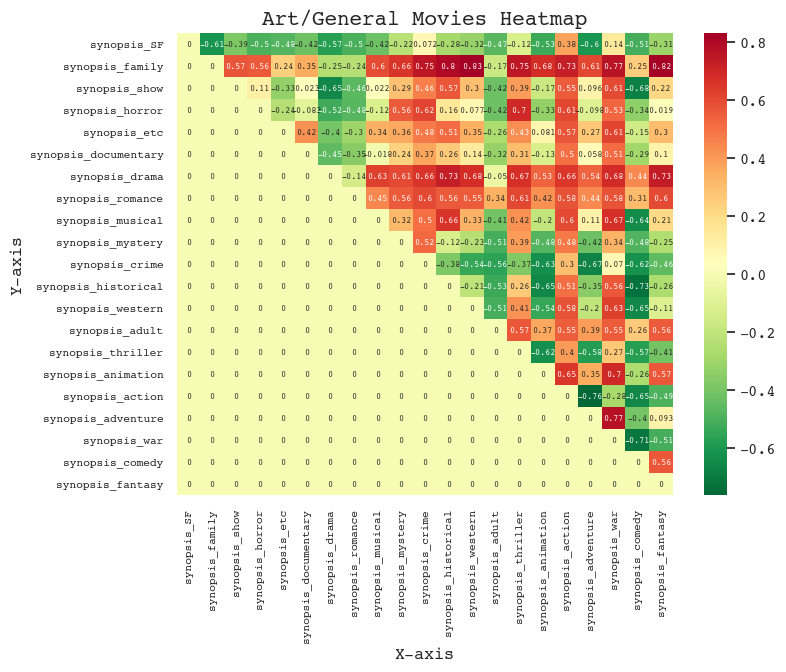

In [416]:
fig = load_var("plot_default_max085")
fig

> 중복단어를 선택하지 않고, TF-IDF max값을 0.85로 조정한 결과,   
> SF에서 WEAT 점수가 높게 나왔던 부분이 많이 줄어들었다.  
> 그러나... family, drama, romance 등의 장르에서 거의 모든 WEAT 점수가 높게 나온다.  
> 앞서 tfidf 기본값에 중복단어를 제거했을 때와 비슷하게,
> crime, mystery, thriller, action, war 는 일반영화에 가깝다고 결과가 나왔다.  

### TF-IDF: max 0.85 - 중복단어 제거

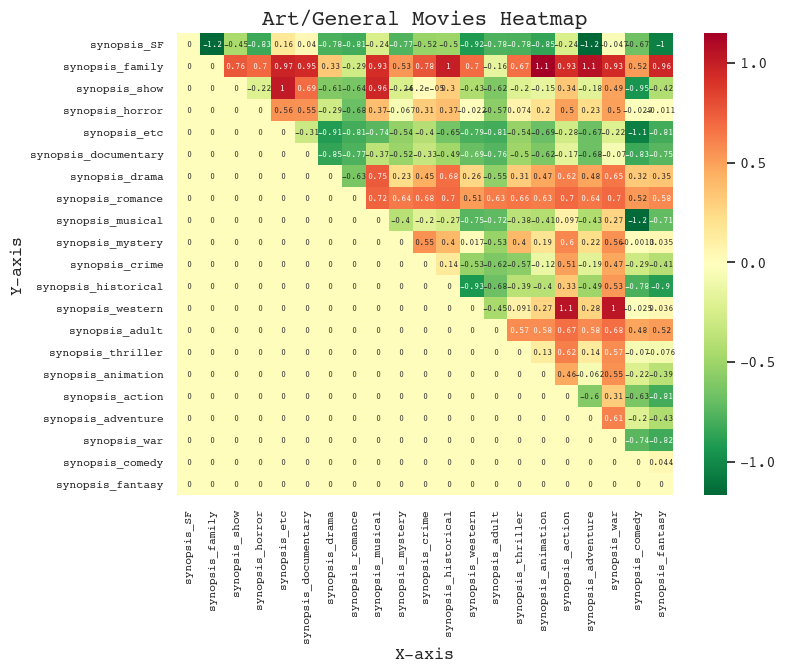

In [71]:
fig = load_var("plot_selection_max085")
fig

> 중복단어를 제거하면, 수치가 조금 줄어든다.  
> SF, etc, documentary, musical, action, war 은 일반 영화로,  
> family, romance, adult 는 예술 영화에 가깝다는 결과가 나온다.  

### TF-IDF: max 0.7

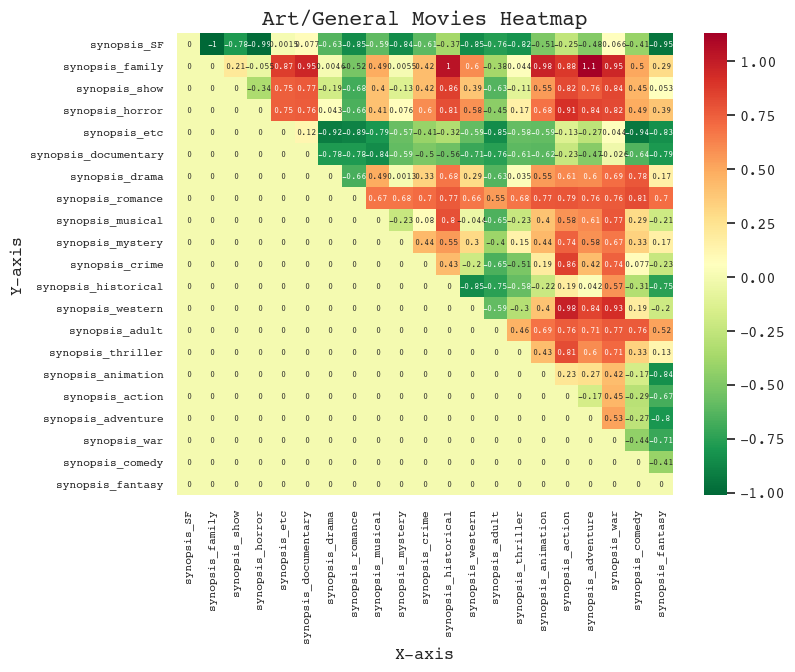

In [118]:
fig = load_var("plot_default_max070")
fig

> tf-idf max 값을 0.7로 더 줄이면,  
> romance, adult 는 예술,  
> SF, etc, documentary, action, advanture, war 는 일반으로 나온다.  

### TF-IDF: default, Mecab

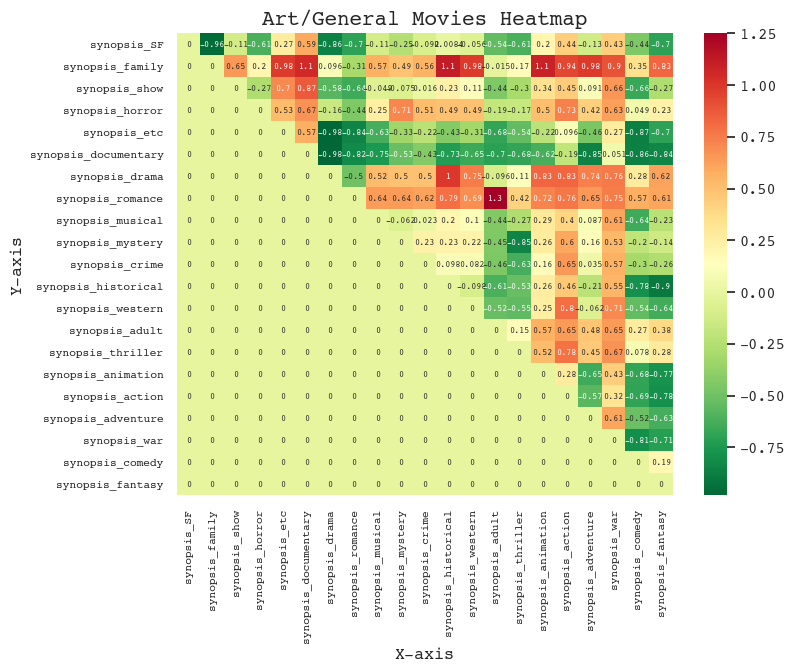

In [227]:
fig = load_var("plot_default_mecab")
fig

> 하나의 장르가 모든 장르에 대해 극단적으로 높은 값이 나오는 현상은 조금 사라진 것으로 보인다.  
> SF 는 가족영화, 드라마에 비해 일반 영화 -- 합리적으로 여겨짐  
> 가족영화는 많은 장르에 대해 예술 영화 -- 그런가..?   
> 다큐멘터리, 기타 장르는 다른 장르에 대해 일반 영화  
> 드라마, 로맨스는 다른 장르에 대해 비교적 예술 영화
